In [13]:
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tensorflow.keras.metrics import AUC, Precision, Recall

from art.utils import load_dataset
from art.estimators.classification import SklearnClassifier
from art.estimators.classification import KerasClassifier
import tensorflow as tf 
from tensorflow.python.framework.ops import disable_eager_execution

# i have no idea why this is necessary but it is 
disable_eager_execution()

In [14]:
# DISCLAIMER
# Many of the adversarial attacks take an hour-several hours to generate and complete. 
# As a result, the notebook takes 6+ hours to fully finish running. Run at your own risk.

In [15]:
#helpers to flatten/unflatten images
def img_to_vector(x):
    return np.reshape(x, (x.shape[0], -1))

def vector_to_img(nbr_samples, x):
    return x.reshape(nbr_samples, 32, 32, 3)

In [16]:
# Load data and perform preprocessing
use_art_loader = False
if use_art_loader:
    # Load in the data
    (x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("cifar10"))

    # the _sk versions are modified for using sklearn
    # x is flattened and y is changed from one-hot encoded to a single value
    x_train_sk = np.reshape(x_train, (x_train.shape[0], -1))
    x_test_sk = np.reshape(x_test, (x_test.shape[0], -1))
    y_train_sk = np.argmax(y_train, axis=1)
    y_test_sk = np.argmax(y_test, axis=1)

    # _small versions contain only a subset of x and y
    # Used for SVC, otherwise it is very slow
    x_train_small, y_train_small = x_train[:20000], y_train[:20000]
    x_test_small, y_test_small = x_test[:4000], y_test[:4000]

    # the _sk versions are modified for using sklearn
    # x is flattened and y is changed from one-hot encoded to a single value
    x_train_small_sk = np.reshape(x_train_small, (x_train_small.shape[0], -1))
    x_test_small_sk = np.reshape(x_test_small, (x_test_small.shape[0], -1))
    y_train_small_sk = np.argmax(y_train_small, axis=1)
    y_test_small_sk = np.argmax(y_test_small, axis=1)
else:
    # Use TensorFlow cifar-10 data loader
    cifar10 = tf.keras.datasets.cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    random_train_split = False
    if random_train_split:
        # Combine train/test data and resplit randomly
        print(type(x_train))
        x = np.concatenate((x_train, x_test))
        y = np.concatenate((y_train, y_test))
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=3000)
    # Convert y from column vector to array
#    y_train = y_train.ravel()
#    y_test = y_test.ravel()
    
    # Temporarily reduct data sizes
    reduce_data_size = False
    if reduce_data_size:
        x_train = x_train[:20000]
        y_train = y_train[:20000]
        x_test = x_test[:5000]
        y_test = y_test[:5000]
    #normalize data 
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    #pixels have values between 0 and 255
    x_train  /= 255
    x_test /= 255

    # the _sk versions are modified for using sklearn
    # x is flattened 
    x_train_sk = np.reshape(x_train, (x_train.shape[0], -1))
    x_test_sk = np.reshape(x_test, (x_test.shape[0], -1))
    y_train_sk = y_train.ravel()
    y_test_sk = y_test.ravel()
    
    
    # For CNN models, y should be one-hot encoded, ie, a list of binary values
#    enc = OneHotEncoder(sparse=False, dtype='int8')
#    y_train = enc.fit_transform(y_train)
#    y_test = enc.fit_transform(y_test)
    y_train = tf.keras.utils.to_categorical(y_train , num_classes=10, dtype='int8')
    y_test = tf.keras.utils.to_categorical(y_test , num_classes=10, dtype='int8')

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

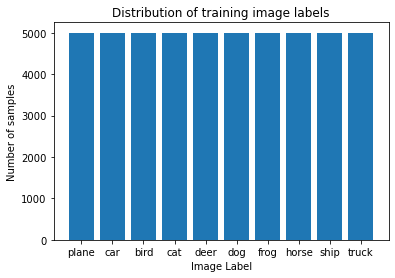

In [133]:
unique, counts = np.unique(y_train_sk, return_counts=True)
fig = plt.figure()
plt.bar(classes, counts)
plt.xlabel("Image Label")
plt.ylabel("Number of samples")
plt.title("Distribution of training image labels")
plt.show()

In [17]:
%matplotlib inline

def display_imgs(rows, cols, imgs):
    f, ax_list = plt.subplots(rows, cols, figsize=(8, 8))
    for r in range(rows):
        for c in range(cols):
          ax_list[r, c].imshow(imgs[r * cols + c])
          ax_list[r,c].axis('off')
    plt.show()

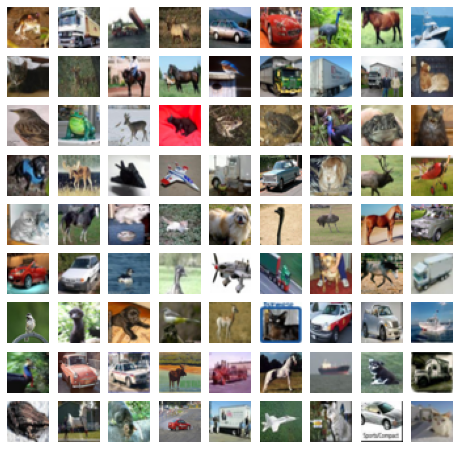

In [18]:
display_imgs(9, 9, x_train)

In [19]:
# Saves a model to a file using pickle
def save_model(model, name):
    filename = name + '-model.pkl'
    print(f'Saving {filename}')
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
       pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)

In [20]:
# Loads a model from a pickle file
def load_model(name):
    filename = name + '-model.pkl'
    with open(filename, 'rb') as inp:
        model = pickle.load(inp)
        return model    

In [21]:
# Saves a model to a file using pickle
def save_images(imgs, name):
    filename = name + '-images.pkl'
    print(f'Saving {filename}')
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
       pickle.dump(imgs, outp, pickle.HIGHEST_PROTOCOL)

In [22]:
# Loads adversarialimages from a pickle file
def load_images(name):
    filename = name + '-images.pkl'
    with open(filename, 'rb') as inp:
        images = pickle.load(inp)
        return images 

In [23]:
from sklearn.decomposition import PCA
# Run PCA to reduce number of features
pca = PCA(.90) # number of components to cover 90%

x_train_pca = pca.fit_transform(x_train_sk)
x_test_pca = pca.transform(x_test_sk)

print(x_train_pca.shape, pca.components_.shape)

(50000, 99) (99, 3072)


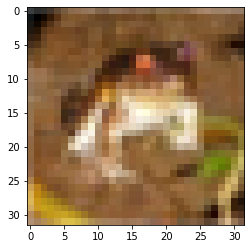

In [24]:
# Example of one original training image
plt.imshow(x_train_sk[0].reshape(32,32,3))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


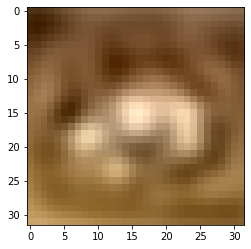

In [25]:
# Example of image using inverse transform of PCA data
# Still semi-recognizable
x_train_pca_inv = pca.inverse_transform(x_train_pca)
plt.imshow(x_train_pca_inv[0].reshape(32, 32, 3))
plt.show()

p=0.4
  Nbr components: 2
p=0.5
  Nbr components: 4
p=0.6
  Nbr components: 8
p=0.7
  Nbr components: 14
p=0.8
  Nbr components: 32
p=0.9
  Nbr components: 98
p=0.95
  Nbr components: 214


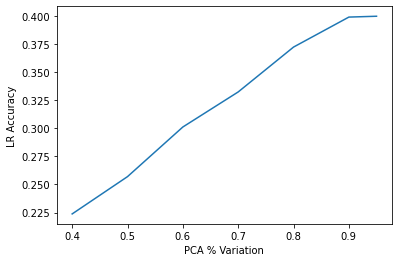

In [27]:
# See how number of components affects accuracy
y_acc = []
x_acc = []
# _small versions contain only a subset of x and y
# Used for SVC, otherwise it is very slow
x_train_small, y_train_small = x_train[:20000], y_train[:20000]
x_test_small, y_test_small = x_test[:4000], y_test[:4000]

# the _sk versions are modified for using sklearn
# x is flattened and y is changed from one-hot encoded to a single value
x_train_small_sk = np.reshape(x_train_small, (x_train_small.shape[0], -1))
x_test_small_sk = np.reshape(x_test_small, (x_test_small.shape[0], -1))
y_train_small_sk = np.argmax(y_train_small, axis=1)
y_test_small_sk = np.argmax(y_test_small, axis=1)
for p in [.4, .5, .6, .7, .8, .9, .95]:
    print(f'p={p}')
    pca_p = PCA(p)
    x_train_small_pcap = pca_p.fit_transform(x_train_small_sk)
    x_test_small_pcap = pca_p.transform(x_test_small_sk)
    print(f'  Nbr components: {pca_p.n_components_}')
    clf_lr_p = LogisticRegression(solver='saga', multi_class='multinomial', tol=0.01)
    clf_lr_p.fit(x_train_small_pcap, y_train_small_sk)
    predict = clf_lr_p.predict(x_test_small_pcap)
    accuracy = metrics.accuracy_score(y_test_small_sk, predict)
    x_acc.append(p)
    y_acc.append(accuracy)
plt.plot(x_acc, y_acc)
plt.xlabel('PCA % Variation')
plt.ylabel('LR Accuracy')
plt.show()   

In [28]:
# Look at confusion matrix
# Helper to plot a confusion matrix for a classifier
def clf_cm(clf, X_test, y_test, title):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    pred = clf.predict(X_test)
    if y_test.ndim > 1:
        # one-hot encoded y's and predictions - collapse to 1 dimension
        y_test = np.argmax(y_test, axis=1)
        pred = np.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, pred) * 100 / X_test.shape[0]
    cm_plt = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(title + ' (percentages)')
    cm_plt.plot(ax=ax, xticks_rotation=45)
    plt.grid(False)

In [29]:
# Compute metrics for a model. Returns results in a dictionary
def model_metrics(model, X_test, y_test):
    pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, pred)
    y_prob = model.predict_proba(X_test)
    macro_roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
    # Accumulate metrics
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test, pred, average='macro')
    results = {'Accuracy': accuracy, 'Precision': precision,
               'Recall': recall, 'F1': f1, 'AUC': macro_roc_auc}

    return results

In [30]:
# Plot multi-class ROC curve just using multi-class predictions
# The is based on the source code for the yellowbrick package
# https://github.com/DistrictDataLabs/yellowbrick/blob/develop/yellowbrick/classifier/rocauc.py
# The yellowbrick code seemed to only work with an sklearn classifier, so this is an
# adaptation to only require the true y values, and the predicted probabilities.
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def multiclass_roc_plot(y, y_pred, title):
    # If y is not one-hot encoded, take care of that.
    if y.ndim == 1:
        y = tf.keras.utils.to_categorical(y, num_classes=10, dtype='int8')
    plt.figure(figsize = (10,7))

    # Save fpr, trp, roc per class in lists so that macro averages can be computed
    n_classes = len(classes)
    fpr = [None] * n_classes
    tpr = [None] * n_classes
    roc_auc = [None] * n_classes
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} AUC = {roc_auc[i]:0.2f}')
       
    # Compute macro average scores
    # Next chunk comes from yellowbrick library
    # Gather all FPRs
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    avg_tpr = np.zeros_like(all_fpr)

    # Compute the averages per class
    for i in range(n_classes):
        avg_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finalize the average
    avg_tpr /= n_classes

    # Draw the macro average ROC curve and compute macro average AUC
    fpr_macro = all_fpr
    tpr_macro = avg_tpr
    roc_auc_macro = metrics.auc(fpr_macro, tpr_macro)
    plt.plot(fpr_macro, tpr_macro, linestyle=':', lw=3, label=f'Macro average AUC = {roc_auc_macro:0.2f}')
   
    plt.legend(loc="lower right")
    plt.title(title)
    plt.plot([0, 1], [0, 1], linestyle=":", c='black')
    plt.grid(False)
    plt.show()

In [31]:
def roc_multi2(clf, X_train, y_train, X_test, y_test, title):
    classifier = OneVsRestClassifier(clf)
    y_pred = classifier.fit(X_train, y_train).predict_proba(X_test)
    multiclass_roc_plot(y_test, y_pred, title)

In [32]:
from sklearn.model_selection import GridSearchCV
# Helper to run GridSearchCV
def runGridSearch(estimator, parameters, x_train, y_train, x_test, y_test):
    print(f'*****Estimator: {estimator} ********')
    gscv = GridSearchCV(estimator=estimator, param_grid=parameters, verbose=4, n_jobs=4, refit=True)
    gscv.fit(x_train, y_train)
    df = pd.DataFrame(gscv.cv_results_)
    display(df)
    print(gscv.best_estimator_)
    print(f'   Best train score: {gscv.best_score_}')
    best_est = gscv.best_estimator_
    predict = best_est.predict(x_test)
    # save model
    with open(type(best_est).__name__ + '.pkl', 'wb') as outp:  # Overwrites any existing file.
       pickle.dump((x_test, y_test), outp, pickle.HIGHEST_PROTOCOL)
    print(f'   test accuracy={metrics.accuracy_score(y_test, predict)}')  
    print(f'   Best params: {gscv.best_params_}')
    return best_est

In [33]:
use_pca = True  # set to false to use 'real' image data
if use_pca:
    x_train_run = x_train_pca
    x_test_run = x_test_pca
else:
    x_train_run = x_train_sk
    x_test_run = x_test_sk

In [34]:
# Create dictionary to hold results from all trials
# Key is a model abbreviation (eg, DT for DecisionTree) followed by a string indicating
# options (eg, 'df' for DeepFool attack on the model)
# Each value is a dictionary with keys identifying the metric or other piece of information
all_results = {}

In [35]:
# Run GridSearchCV on LDA options
lda_parameters = {'solver': ('svd', 'lsqr')}
lda_clf = runGridSearch(LinearDiscriminantAnalysis(), lda_parameters, x_train_run, y_train_sk, x_test_run, y_test_sk)

*****Estimator: LinearDiscriminantAnalysis() ********
Fitting 5 folds for each of 2 candidates, totalling 10 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_solver  \
0       0.620296      0.079817         0.006051        0.001105          svd   
1       0.342339      0.019465         0.006250        0.001555         lsqr   

               params  split0_test_score  split1_test_score  \
0   {'solver': 'svd'}             0.3964             0.3872   
1  {'solver': 'lsqr'}             0.3964             0.3872   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0             0.4037             0.3989             0.3872          0.39468   
1             0.4037             0.3989             0.3872          0.39468   

   std_test_score  rank_test_score  
0        0.006543                1  
1        0.006543                1

LinearDiscriminantAnalysis()
   Best train score: 0.39468000000000003
   test accuracy=0.3989
   Best params: {'solver': 'svd'}


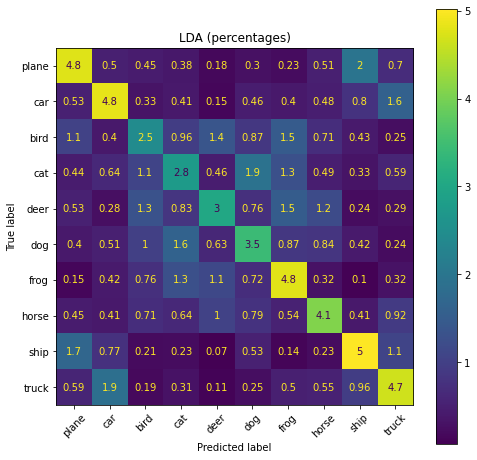

In [36]:
clf_cm(lda_clf, x_test_run, y_test_sk, 'LDA')

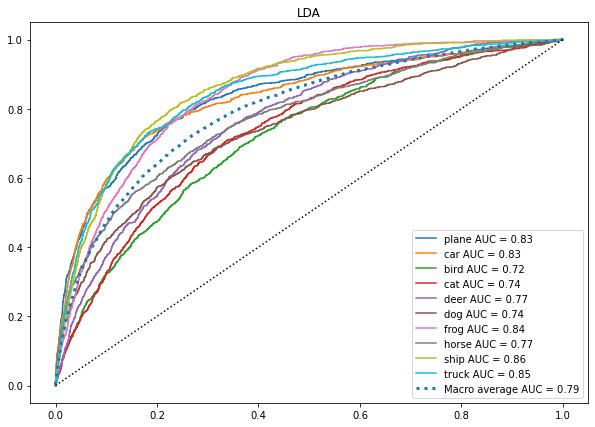

In [37]:
roc_multi2(lda_clf, x_train_run, y_train, x_test_run, y_test, 'LDA')

In [38]:
# Accumulate metrics
lda_results = model_metrics(lda_clf, x_test_run, y_test_sk)
all_results['LDA'] = lda_results
lda_results

{'Accuracy': 0.3989,
 'Precision': 0.39483540616038404,
 'Recall': 0.3989,
 'F1': 0.39582202203780226,
 'AUC': 0.8122665444444446}

In [39]:
# Run GridSearchCV on logistic Regression options
from sklearn.linear_model import LogisticRegression
lr_parameters = {'penalty': ('l2', 'none'), 'tol': (1.0e-2, 1.0e-4)}
lr_model = LogisticRegression(solver='saga', multi_class='multinomial')
lr_clf = runGridSearch(lr_model, lr_parameters, x_train_run, y_train_sk, x_test_run, y_test_sk)

*****Estimator: LogisticRegression(multi_class='multinomial', solver='saga') ********
Fitting 5 folds for each of 4 candidates, totalling 20 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_penalty  \
0       1.432647      0.162037         0.002280    2.417742e-04            l2   
1       9.272421      5.969467         0.001884    1.978738e-04            l2   
2       1.318566      0.098472         0.001886    1.966242e-04          none   
3       2.811725      0.157214         0.001984    1.784161e-07          none   

  param_tol                              params  split0_test_score  \
0      0.01      {'penalty': 'l2', 'tol': 0.01}             0.4029   
1    0.0001    {'penalty': 'l2', 'tol': 0.0001}             0.4031   
2      0.01    {'penalty': 'none', 'tol': 0.01}             0.4031   
3    0.0001  {'penalty': 'none', 'tol': 0.0001}             0.4032   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0             0.3862             0.4057             0.3941             0.3913   
1             0.3869             0.4061             0.3956             0.3914   
2             0.3863             0.4066             0.3949             0.3910   
3             0.3866             0.4065             0.3956             0.3915   

   mean_test_score  std_test_score  rank_test_score  
0          0.39604        0.007259                4  
1          0.39662        0.007136                2  
2          0.39638        0.007515                3  
3          0.39668        0.007329                1

LogisticRegression(multi_class='multinomial', penalty='none', solver='saga')
   Best train score: 0.39668
   test accuracy=0.4022
   Best params: {'penalty': 'none', 'tol': 0.0001}


In [40]:
lr_clf = LogisticRegression(solver='saga', multi_class='multinomial', penalty='l2', tol=.01)
lr_clf.fit(x_train_run, y_train_sk)

LogisticRegression(multi_class='multinomial', solver='saga', tol=0.01)

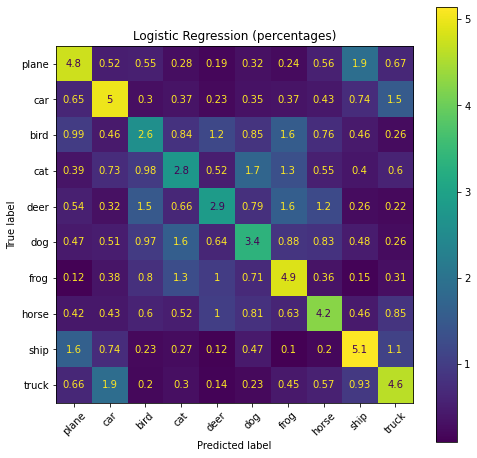

In [41]:
clf_cm(lr_clf, x_test_run, y_test_sk, 'Logistic Regression')

In [42]:
# Accumulate metrics
lr_results = model_metrics(lr_clf, x_test_run, y_test_sk)
all_results['LogisticRegression'] = lr_results
lr_results

{'Accuracy': 0.4021,
 'Precision': 0.3971356142397978,
 'Recall': 0.40210000000000007,
 'F1': 0.3982894982977053,
 'AUC': 0.8145077722222223}

In [43]:
print(model_metrics(lr_clf, x_test_run, y_test_sk))

{'Accuracy': 0.4021, 'Precision': 0.3971356142397978, 'Recall': 0.40210000000000007, 'F1': 0.3982894982977053, 'AUC': 0.8145077722222223}


C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

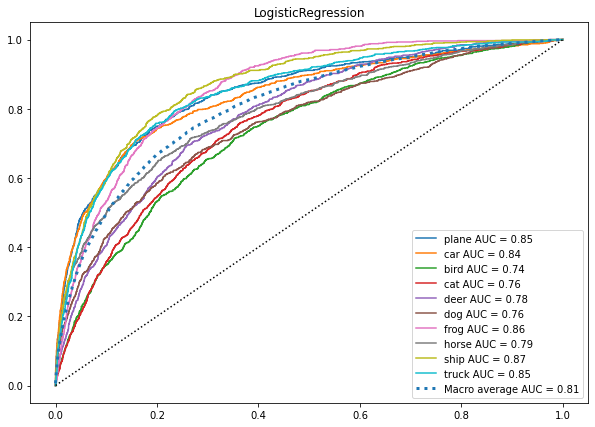

In [44]:
roc_multi2(lr_model, x_train_run, y_train_sk, x_test_run, y_test_sk, 'LogisticRegression')

In [45]:
# Run GridSearchCV on decision tree options
dt_parameters = {'max_depth': (10, 20, 50), 'max_features': ('auto', None)}
dt_clf = runGridSearch(DecisionTreeClassifier(), dt_parameters, x_train_run, y_train_sk, x_test_run, y_test_sk)

*****Estimator: DecisionTreeClassifier() ********
Fitting 5 folds for each of 6 candidates, totalling 30 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.321307      0.003923         0.002878    4.867746e-04   
1       3.173016      0.014945         0.002568    2.073019e-04   
2       0.484196      0.015128         0.003471    3.140211e-04   
3       4.496338      0.018586         0.003472    1.507891e-07   
4       0.496496      0.010418         0.003869    1.982212e-04   
5       4.629177      0.090341         0.003367    3.595594e-04   

  param_max_depth param_max_features  \
0              10               auto   
1              10               None   
2              20               auto   
3              20               None   
4              50               auto   
5              50               None   

                                      params  split0_test_score  \
0  {'max_depth': 10, 'max_features': 'auto'}             0.2459   
1    {'max_depth': 10, 'max_features': None}             0.3042   
2  {'max_depth': 20, 'max_features': 'auto'}             0.2321   
3    {'max_depth': 20, 'max_features': None}             0.2648   
4  {'max_depth': 50, 'max_features': 'auto'}             0.2210   
5    {'max_depth': 50, 'max_features': None}             0.2572   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0             0.2553             0.2527             0.2454             0.2400   
1             0.2969             0.3137             0.3065             0.3141   
2             0.2286             0.2217             0.2338             0.2225   
3             0.2604             0.2755             0.2696             0.2663   
4             0.2119             0.2123             0.2153             0.2160   
5             0.2498             0.2662             0.2625             0.2602   

   mean_test_score  std_test_score  rank_test_score  
0          0.24786        0.005485                4  
1          0.30708        0.006409                1  
2          0.22774        0.004907                5  
3          0.26732        0.005048                2  
4          0.21530        0.003272                6  
5          0.25918        0.005536                3

DecisionTreeClassifier(max_depth=10)
   Best train score: 0.30707999999999996
   test accuracy=0.3122
   Best params: {'max_depth': 10, 'max_features': None}


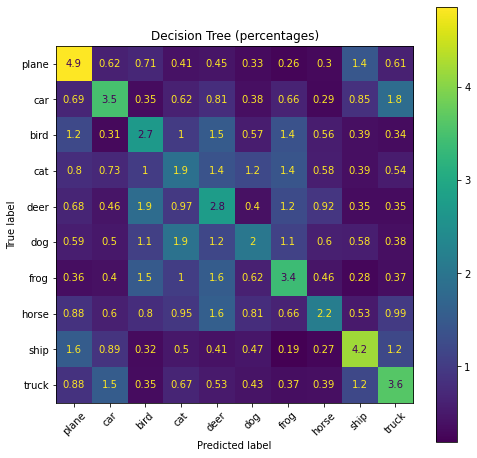

In [46]:
clf_cm(dt_clf, x_test_run, y_test_sk, 'Decision Tree')

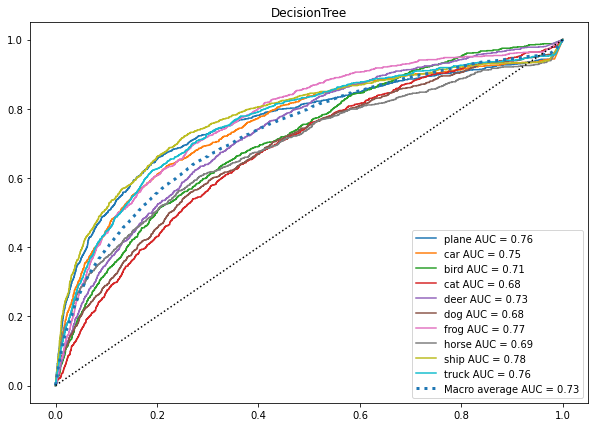

In [47]:
roc_multi2(dt_clf, x_train_run, y_train_sk, x_test_run, y_test_sk, 'DecisionTree')

In [48]:
dt_results = model_metrics(dt_clf, x_test_run, y_test_sk)
# Accumulate metrics
all_results['DecisionTree'] = dt_results
print('DecisionTree Metrics', dt_results)

DecisionTree Metrics {'Accuracy': 0.3122, 'Precision': 0.31231806693346587, 'Recall': 0.3122, 'F1': 0.3095621763438264, 'AUC': 0.7303298944444443}


In [49]:
# Run GridSearchCV on AdaBoost options
ab_parameters = {'base_estimator': (DecisionTreeClassifier(), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=4)),
                 'n_estimators': (100, 200, 300)}
ab_clf = runGridSearch(AdaBoostClassifier(), ab_parameters, x_train_run, y_train_sk, x_test_run, y_test_sk)

*****Estimator: AdaBoostClassifier() ********
Fitting 5 folds for each of 9 candidates, totalling 45 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.797708      0.021971         0.007142        0.000397   
1       4.838877      0.073502         0.006944        0.000314   
2       4.791460      0.059221         0.007142        0.000397   
3      81.163257      0.122208         0.334105        0.026162   
4     162.776877      0.668190         0.628833        0.049472   
5     244.220771      0.705231         0.849745        0.080606   
6     155.861548      0.105226         0.259408        0.020000   
7     312.123757      0.443806         0.529333        0.033921   
8     463.312891      7.047398         0.771874        0.065009   

                  param_base_estimator param_n_estimators  \
0             DecisionTreeClassifier()                100   
1             DecisionTreeClassifier()                200   
2             DecisionTreeClassifier()                300   
3  DecisionTreeClassifier(max_depth=2)                100   
4  DecisionTreeClassifier(max_depth=2)                200   
5  DecisionTreeClassifier(max_depth=2)                300   
6  DecisionTreeClassifier(max_depth=4)                100   
7  DecisionTreeClassifier(max_depth=4)                200   
8  DecisionTreeClassifier(max_depth=4)                300   

                                              params  split0_test_score  \
0  {'base_estimator': DecisionTreeClassifier(), '...             0.2607   
1  {'base_estimator': DecisionTreeClassifier(), '...             0.2604   
2  {'base_estimator': DecisionTreeClassifier(), '...             0.2575   
3  {'base_estimator': DecisionTreeClassifier(max_...             0.3801   
4  {'base_estimator': DecisionTreeClassifier(max_...             0.3916   
5  {'base_estimator': DecisionTreeClassifier(max_...             0.3873   
6  {'base_estimator': DecisionTreeClassifier(max_...             0.3864   
7  {'base_estimator': DecisionTreeClassifier(max_...             0.3677   
8  {'base_estimator': DecisionTreeClassifier(max_...             0.3596   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0             0.2528             0.2668             0.2588             0.2577   
1             0.2488             0.2656             0.2612             0.2593   
2             0.2513             0.2686             0.2578             0.2623   
3             0.3730             0.3874             0.3741             0.3864   
4             0.3768             0.3904             0.3800             0.3939   
5             0.3788             0.3891             0.3794             0.3902   
6             0.3691             0.3785             0.3660             0.3784   
7             0.3569             0.3702             0.3564             0.3695   
8             0.3538             0.3634             0.3604             0.3623   

   mean_test_score  std_test_score  rank_test_score  
0          0.25936        0.004544                8  
1          0.25906        0.005558                9  
2          0.25950        0.005741                7  
3          0.38020        0.005989                3  
4          0.38654        0.006816                1  
5          0.38496        0.004877                2  
6          0.37568        0.007311                4  
7          0.36414        0.006172                5  
8          0.35990        0.003333                6

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=200)
   Best train score: 0.38654
   test accuracy=0.3845
   Best params: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'n_estimators': 200}


In [50]:
# AdaBoost can take some time
load_ab_model = False
if load_ab_model:
    ab_clf = load_model('AdaBoost')
else:
    # Accuracy doesn't change much between 100, 200, and 300 estimators
    ab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=200)
    ab_clf.fit(x_train_run, y_train_sk)
    save_model(ab_clf, 'AdaBoost')

Saving AdaBoost-model.pkl


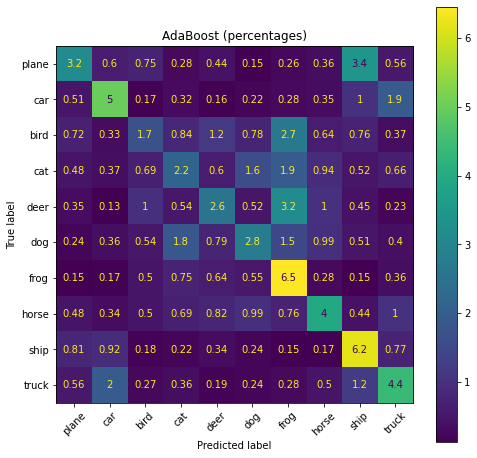

In [51]:
clf_cm(ab_clf, x_test_run, y_test_sk, 'AdaBoost')

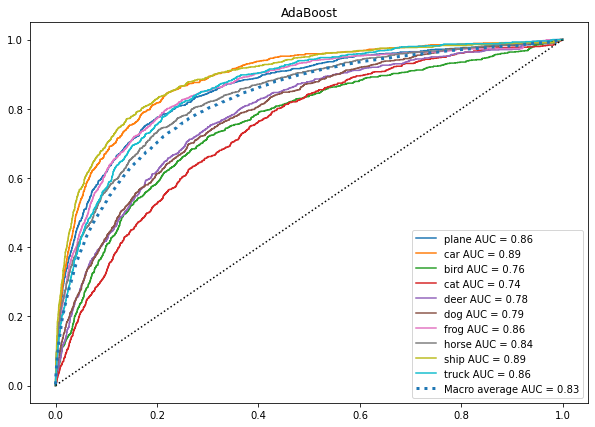

In [52]:
# This is slow
roc_multi2(ab_clf, x_train_run, y_train, x_test_run, y_test, 'AdaBoost')

In [53]:
# Accumulate metrics
ab_results = model_metrics(ab_clf, x_test_run, y_test_sk)
all_results['AdaBoost'] = ab_results
ab_results

{'Accuracy': 0.3846,
 'Precision': 0.3766449321062142,
 'Recall': 0.3846,
 'F1': 0.3718073034328514,
 'AUC': 0.8096281666666666}

In [54]:
# Run GridSearchCV on Random Forest options
rf_parameters = {'n_estimators': (25,50,100), 'max_depth':(10,50,100)}
rf_clf = runGridSearch(RandomForestClassifier(n_jobs=4), rf_parameters, x_train_run, y_train_sk, x_test_run, y_test_sk)

*****Estimator: RandomForestClassifier(n_jobs=4) ********
Fitting 5 folds for each of 9 candidates, totalling 45 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.123775      0.013577         0.019541        0.003327   
1       4.102018      0.071220         0.029859        0.002982   
2       8.035596      0.180870         0.055750        0.005264   
3       3.245129      0.075691         0.030256        0.000830   
4       6.105661      0.100886         0.050592        0.000701   
5      12.062918      0.077705         0.106839        0.017850   
6       3.278758      0.064999         0.028471        0.001618   
7       6.176787      0.048773         0.051386        0.002047   
8      11.496388      1.077829         0.089378        0.008902   

  param_max_depth param_n_estimators                                   params  \
0              10                 25    {'max_depth': 10, 'n_estimators': 25}   
1              10                 50    {'max_depth': 10, 'n_estimators': 50}   
2              10                100   {'max_depth': 10, 'n_estimators': 100}   
3              50                 25    {'max_depth': 50, 'n_estimators': 25}   
4              50                 50    {'max_depth': 50, 'n_estimators': 50}   
5              50                100   {'max_depth': 50, 'n_estimators': 100}   
6             100                 25   {'max_depth': 100, 'n_estimators': 25}   
7             100                 50   {'max_depth': 100, 'n_estimators': 50}   
8             100                100  {'max_depth': 100, 'n_estimators': 100}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0             0.4024             0.3918             0.4075             0.3968   
1             0.4295             0.4242             0.4265             0.4115   
2             0.4366             0.4269             0.4343             0.4291   
3             0.3776             0.3775             0.3733             0.3724   
4             0.4198             0.4152             0.4221             0.4208   
5             0.4536             0.4451             0.4568             0.4511   
6             0.3749             0.3743             0.3736             0.3711   
7             0.4237             0.4138             0.4228             0.4128   
8             0.4607             0.4476             0.4511             0.4477   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0             0.3956          0.39882        0.005512                7  
1             0.4163          0.42160        0.006683                4  
2             0.4286          0.43110        0.003698                3  
3             0.3855          0.37726        0.004634                8  
4             0.4265          0.42088        0.003647                5  
5             0.4535          0.45202        0.003906                1  
6             0.3776          0.37430        0.002097                9  
7             0.4279          0.42020        0.005899                6  
8             0.4510          0.45162        0.004788                2

RandomForestClassifier(max_depth=50, n_jobs=4)
   Best train score: 0.4520200000000001
   test accuracy=0.4701
   Best params: {'max_depth': 50, 'n_estimators': 100}


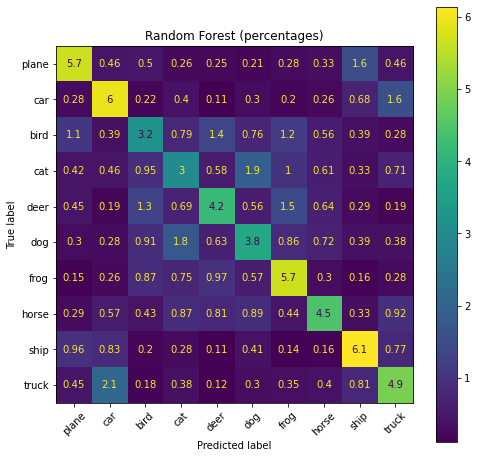

In [55]:
clf_cm(rf_clf, x_test_run, y_test_sk, 'Random Forest')

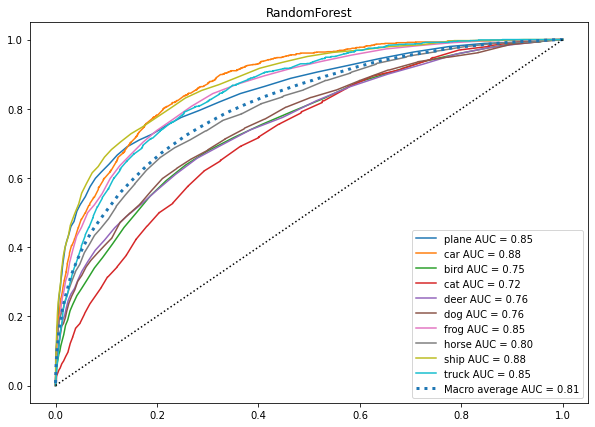

In [56]:
roc_multi2(rf_clf, x_train_run, y_train, x_test_run, y_test, 'RandomForest')

In [57]:
# Accumulate metrics
rf_results = model_metrics(rf_clf, x_test_run, y_test_sk)
all_results['RandomForest'] = rf_results
rf_results

{'Accuracy': 0.4701,
 'Precision': 0.466211475649455,
 'Recall': 0.47009999999999996,
 'F1': 0.4667582267422197,
 'AUC': 0.8476863}

In [58]:
from sklearn.svm import LinearSVC

# Run GridSearchCV on LinearSVC
grid_search_lsvc = False
if grid_search_lsvc:
    lsvc_parameters = {'C': (.5, 1, 2), 'dual': (False, True)}
    lsvc_clf = runGridSearch(LinearSVC(), lsvc_parameters, x_train_run, y_train_sk, x_test_run, y_test_sk)
else:
    lsvc_clf = LinearSVC(C=0.5, dual='False')

In [59]:
from sklearn.calibration import CalibratedClassifierCV
# To be able to plot ROC, we need predicted probabilities which LinearSVC does not provide
# Nest it in CalibratedClassifier to get those
# Use model parameters from GridSearch in previous cell
lsvc2_clf = CalibratedClassifierCV(LinearSVC(C=0.5, max_iter=1500, tol=1e-3))
lsvc2_clf.fit(x_train_run, y_train_sk)

C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.5, max_iter=1500,
                                                tol=0.001))

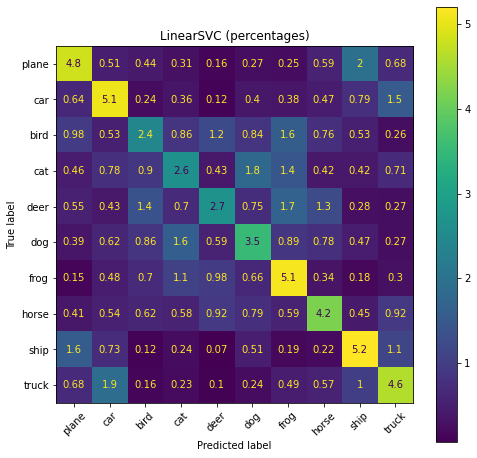

In [60]:
clf_cm(lsvc2_clf, x_test_run, y_test_sk, 'LinearSVC')

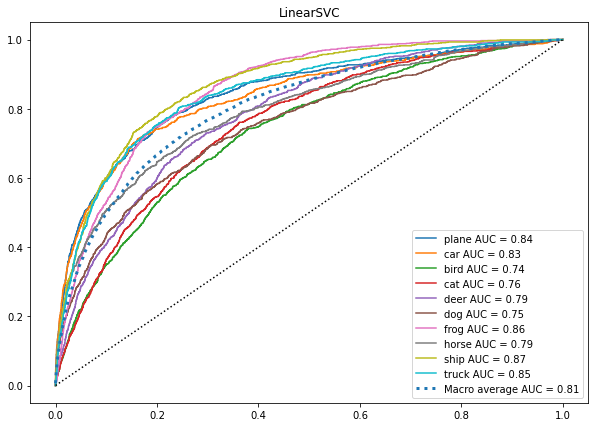

In [61]:
multiclass_roc_plot(y_test, lsvc2_clf.predict_proba(x_test_run), 'LinearSVC')

In [62]:
# Accumulate metrics
lsvc_results = model_metrics(lsvc2_clf, x_test_run, y_test_sk)
all_results['LinearSVC'] = lsvc_results
lsvc_results

{'Accuracy': 0.4031,
 'Precision': 0.3970784537009574,
 'Recall': 0.40309999999999996,
 'F1': 0.3975725257856414,
 'AUC': 0.8077503444444444}

In [63]:
df = pd.DataFrame.from_dict(all_results, orient='index')
pd.set_option("display.precision", 4)
display(df)

Accuracy  Precision  Recall      F1     AUC
LDA                   0.3989     0.3948  0.3989  0.3958  0.8123
LogisticRegression    0.4021     0.3971  0.4021  0.3983  0.8145
DecisionTree          0.3122     0.3123  0.3122  0.3096  0.7303
AdaBoost              0.3846     0.3766  0.3846  0.3718  0.8096
RandomForest          0.4701     0.4662  0.4701  0.4668  0.8477
LinearSVC             0.4031     0.3971  0.4031  0.3976  0.8078

In [64]:
# Generate metrics for a CNN model
# Uses model metrics obtained by calling model.evaluate()
def model_metrics_cnn(model, X, y):
    loss, accuracy, roc_auc, precision, recall = model.evaluate(X, y)
    f1 = 2 * precision * recall / (precision + recall)
    results = {'Accuracy': accuracy, 'Precision': precision,
                   'Recall': recall, 'F1': f1, 'AUC': roc_auc}
    return results

In [65]:
# neural network model
# model from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/adversarial_training_cifar10.py
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential


model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [66]:
# Compile
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy', AUC(name='auc'), Precision(), Recall()])

In [67]:
load_cnn1_model = False
if load_cnn1_model:
    model = tf.keras.models.load_model('CNN1-Model')
    print("CNN1 model loaded")
else:
    history = model.fit(x_train, y_train, validation_split=0.3, epochs=25)
    model.save('CNN1-Model')

Train on 35000 samples, validate on 15000 samples
Epoch 1/25
34976/35000 [============================>.] - ETA: 0s - loss: 1.5662 - accuracy: 0.4258 - auc: 0.8555 - precision: 0.6664 - recall: 0.2013WARNING:tensorflow:From C:\Users\mdsco\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
35000/35000 [==============================] - 44s 1ms/sample - loss: 1.5662 - accuracy: 0.4259 - auc: 0.8555 - precision: 0.6663 - recall: 0.2013 - val_loss: 1.2101 - val_accuracy: 0.5636 - val_auc: 0.9169 - val_precision: 0.7397 - val_recall: 0.3827
Epoch 2/25
35000/35000 [==============================] - 44s 1ms/sample - loss: 1.1808 - accuracy: 0.5840 - auc: 0.9205 - precision: 0.7403 - recall: 0.4156 - val_loss: 1.0783 - val_accurac

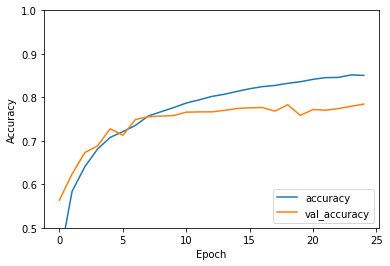

In [68]:
if not load_cnn1_model:
    #history only available after calling model.fit()
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

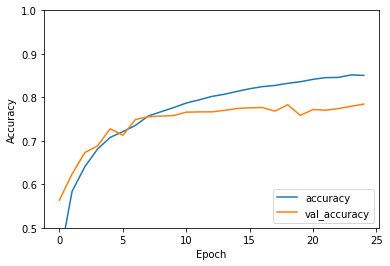

In [69]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [70]:
cnn_results = model_metrics_cnn(model, x_test, y_test)
all_results['CNN'] = cnn_results
cnn_results

{'Accuracy': 0.778,
 'Precision': 0.82159466,
 'Recall': 0.7419,
 'F1': 0.7797162393179389,
 'AUC': 0.9695116}

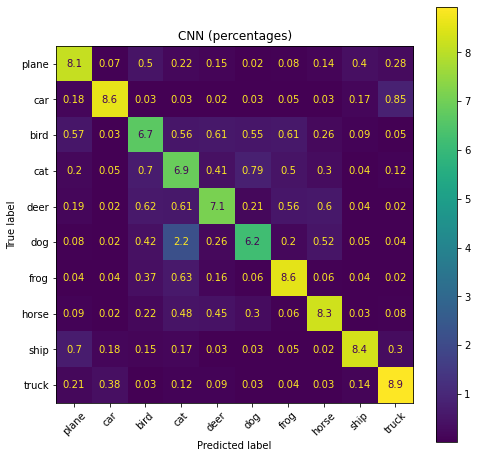

In [71]:
clf_cm(model, x_test, y_test, 'CNN')

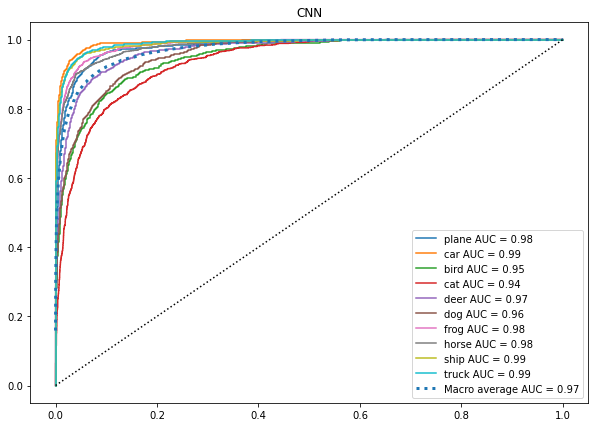

In [72]:
multiclass_roc_plot(y_test, model.predict(x_test), "CNN")

In [73]:
# Create classifier wrappers for trained models
keras_classifier = KerasClassifier(model=model, clip_values=(0, 1))
logreg_classifier = SklearnClassifier(model=lr_model, clip_values=(0, 1))
#svc_classifier = SklearnClassifier(model=svc_model, clip_values=(min_, max_))

#train classifiers 
logreg_classifier.fit(x_train_sk, y_train)
#svc_classifier.fit(x_train, y_train)
keras_classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128)

C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 44s 879us/sample - loss: 0.4989 - accuracy: 0.8376 - auc: 0.9834 - precision: 0.8789 - recall: 0.7985
Epoch 2/10
50000/50000 [==============================] - 44s 880us/sample - loss: 0.4669 - accuracy: 0.8466 - auc: 0.9851 - precision: 0.8885 - recall: 0.8065
Epoch 3/10
50000/50000 [==============================] - 44s 883us/sample - loss: 0.4449 - accuracy: 0.8526 - auc: 0.9862 - precision: 0.8925 - recall: 0.8146
Epoch 4/10
50000/50000 [==============================] - 44s 877us/sample - loss: 0.4310 - accuracy: 0.8542 - auc: 0.9874 - precision: 0.8928 - recall: 0.8182
Epoch 5/10
50000/50000 [==============================] - 44s 881us/sample - loss: 0.4142 - accuracy: 0.8593 - auc: 0.9883 - precision: 0.8975 - recall: 0.8251
Epoch 6/10
50000/50000 [==============================] - 44s 883us/sample - loss: 0.4026 - accuracy: 0.8633 - auc: 0.9887 - precision: 0.8978 - recall: 0.8300
Epoch 7/10
50000/

In [131]:
# DeepFool attack for neural networks
from art.attacks.evasion import DeepFool

load_cnn_df_images = False
if load_cnn_df_images:
    x_test_df_cnn = load_images('CNN1-DF')
else:
    # Craft adversarial samples with DeepFool
    print("Create DeepFool attack samples")
    min_ = 0
    max_= 1
    keras_classifier = KerasClassifier(model=model, clip_values=(min_, max_))
    df_cnn_attack = DeepFool(keras_classifier, epsilon=1.0e-4)
    x_test_df_cnn = df_cnn_attack.generate(x_test)
    save_images(x_test_df_cnn, 'CNN1-DF')    

Create DeepFool attack samples


DeepFool:   0%|          | 0/10000 [00:00<?, ?it/s]

Saving CNN1-DF-images.pkl


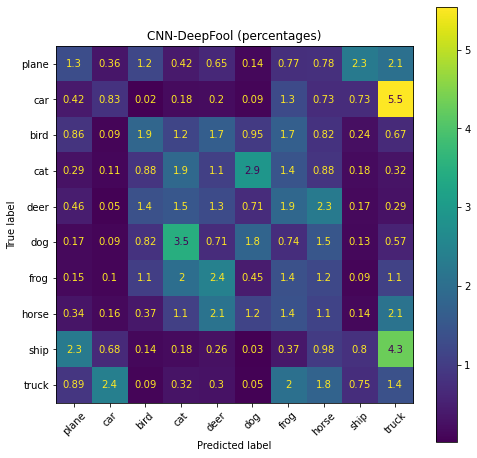

In [75]:
clf_cm(model, x_test_df_cnn, y_test, 'CNN-DeepFool')

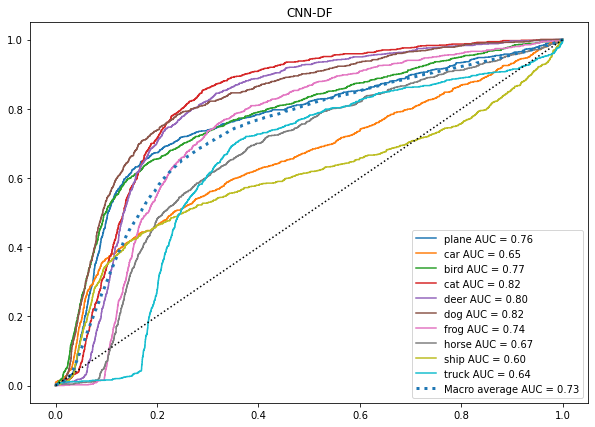

In [76]:
multiclass_roc_plot(y_test, model.predict(x_test_df_cnn), "CNN-DF")

In [77]:
# Compute and save metrics for CNN with DeepFool attack
cnn_df_results = model_metrics_cnn(model, x_test_df_cnn, y_test)
all_results['CNN-DF'] = cnn_df_results
cnn_df_results

{'Accuracy': 0.1366,
 'Precision': 0.069139116,
 'Recall': 0.0412,
 'F1': 0.051632306169095074,
 'AUC': 0.7218344}

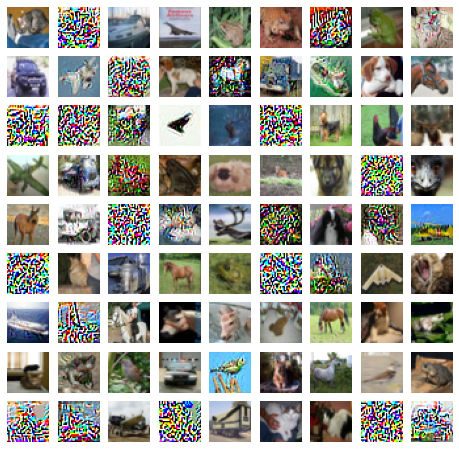

In [78]:
display_imgs(9, 9, x_test_df_cnn)

In [79]:
#Fast gradient method on neural network
from art.attacks.evasion import FastGradientMethod

attack = FastGradientMethod(estimator=keras_classifier, eps=0.1)
x_test_fgm = attack.generate(x=x_test)
preds = np.argmax(model.predict(x_test_fgm), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Accuracy on adversarial samples: ", (acc * 100))

Accuracy on adversarial samples:  21.55


In [80]:
from art.attacks.evasion import FastGradientMethod
#fast gradient method on logistic regression
attack = FastGradientMethod(estimator=logreg_classifier, eps=0.1)
x_test_fgm_sk = attack.generate(x=x_test_sk)
preds = lr_model.predict(x_test_fgm_sk)
acc = lr_model.score(x_test_fgm_sk, y_test_sk)
print("Accuracy on adversarial samples: ", (acc * 100))

Accuracy on adversarial samples:  18.32


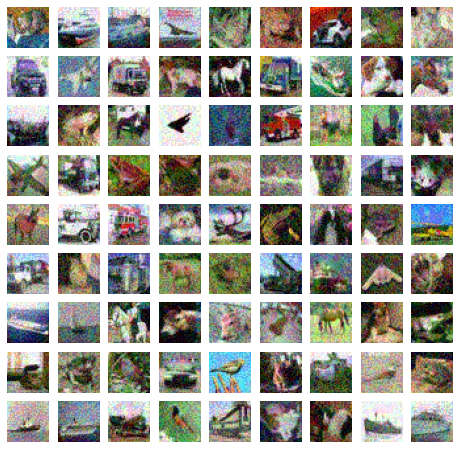

In [81]:
display_imgs(9, 9, x_test_fgm_sk.reshape(x_test_fgm_sk.shape[0], 32, 32, 3))

In [82]:
from art.attacks.evasion import HopSkipJump
print("Create HopSkipJump attack")
load_cnn_hsj_images = False
if load_cnn_hsj_images:
    x_test_hsj_cnn = load_images('CNN1-HSJ')
else:
    hsj_cnn_crafter = HopSkipJump(keras_classifier, max_iter=20, max_eval=100,init_eval=25)
    x_test_hsj_cnn = hsj_cnn_crafter.generate(x_test)
    save_images(x_test_hsj_cnn, 'CNN-HSJ')

Create HopSkipJump attack


HopSkipJump:   0%|          | 0/10000 [00:00<?, ?it/s]

Saving CNN-HSJ-images.pkl


In [83]:
# Compute and save metrics for CNN with DeepFool attack
cnn_hsj_results = model_metrics_cnn(model, x_test_hsj_cnn, y_test)
all_results['CNN-HSJ'] = cnn_hsj_results
cnn_hsj_results

{'Accuracy': 0.0958,
 'Precision': 0.05223647,
 'Recall': 0.0334,
 'F1': 0.04074661563725251,
 'AUC': 0.8762343}

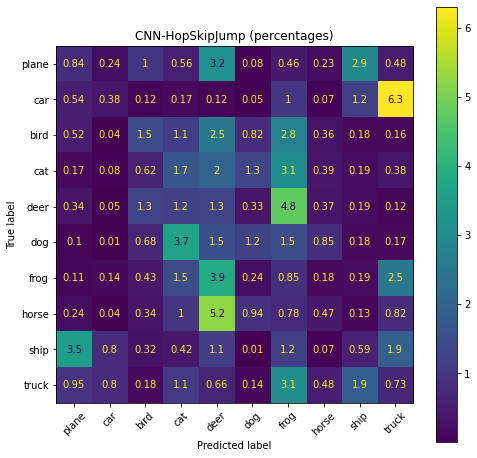

In [84]:
clf_cm(model, x_test_hsj_cnn, y_test, 'CNN-HopSkipJump')

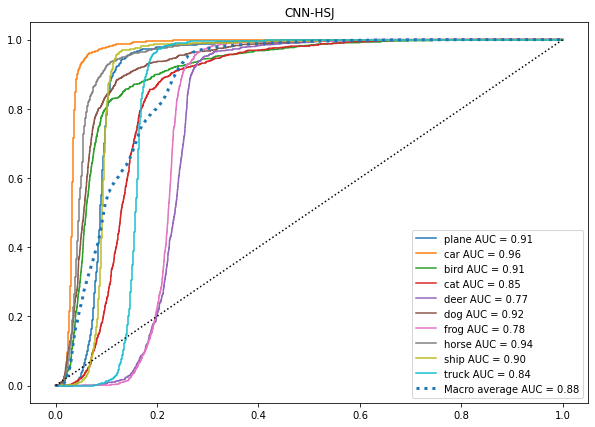

In [85]:
multiclass_roc_plot(y_test, model.predict(x_test_hsj_cnn), "CNN-HSJ")

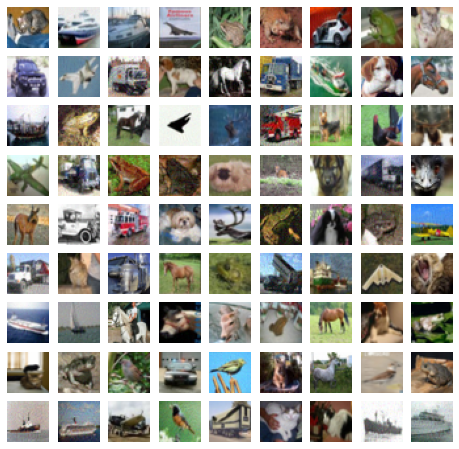

In [86]:
display_imgs(9, 9, x_test_hsj_cnn)

In [87]:
# Try DeepFool attack on LogisticRegression model
load_lr_df_images = False
if load_lr_df_images:
    x_test_df_lr = load_images('LR-DF')
else:
    lr_df_clf = SklearnClassifier(model=lr_clf, clip_values=(np.min(x_test_run), np.max(x_test_sk)))
    attack = DeepFool(lr_df_clf, epsilon=1.0e-5)
    x_test_df_lr = attack.generate(x=x_test_run)
    save_images(x_test_df_lr, 'LR-DF')

DeepFool:   0%|          | 0/10000 [00:00<?, ?it/s]

Saving LR-DF-images.pkl


In [88]:
# Accumulate metrics
lr_df_results = model_metrics(lr_clf, x_test_df_lr, y_test_sk)
all_results['LogisticRegression-DF'] = lr_df_results
lr_df_results

{'Accuracy': 0.1476,
 'Precision': 0.17903560364098395,
 'Recall': 0.1476,
 'F1': 0.15012856072200953,
 'AUC': 0.5525456}

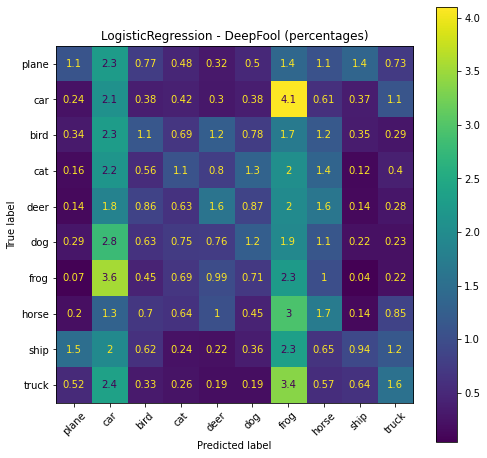

In [89]:
clf_cm(lr_clf, x_test_df_lr, y_test_sk, 'LogisticRegression - DeepFool')

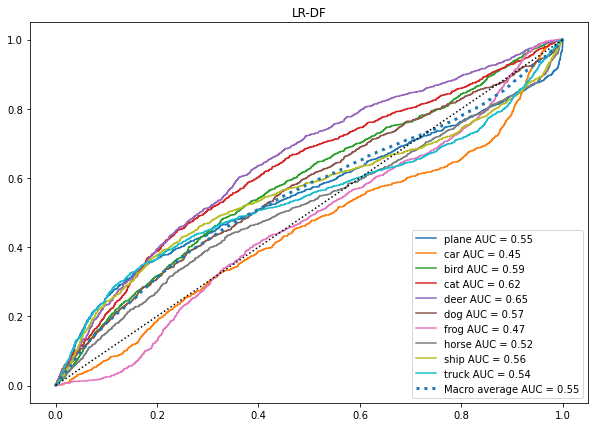

In [90]:
multiclass_roc_plot(y_test, lr_clf.predict_proba(x_test_df_lr), "LR-DF")

In [91]:
# Try HopSkipJump attack on LogisticRegression model
load_lr_hsj_images = False
if load_lr_hsj_images:
    x_test_hsj_lr = load_images('LR-HSJ')
else:
    lr_hsj_clf = SklearnClassifier(model=lr_clf, clip_values=(np.min(x_test_run), np.max(x_test_run)))
    lr_hsj_attack = HopSkipJump(lr_hsj_clf, max_eval=500, max_iter=25)
    x_test_hsj_lr = lr_hsj_attack.generate(x=x_test_run)
    save_images(x_test_hsj_lr, 'LR-HSJ')

HopSkipJump:   0%|          | 0/10000 [00:00<?, ?it/s]

Saving LR-HSJ-images.pkl


In [92]:
# Accumulate metrics
lr_hsj_results = model_metrics(lr_clf, x_test_hsj_lr, y_test_sk)
all_results['LogisticRegression-HSJ'] = lr_hsj_results
lr_hsj_results

{'Accuracy': 0.1675,
 'Precision': 0.16930992423464852,
 'Recall': 0.16749999999999998,
 'F1': 0.16801673991096344,
 'AUC': 0.7813369166666666}

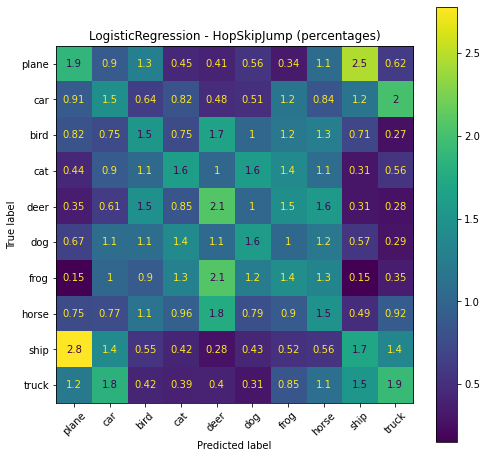

In [93]:
clf_cm(lr_clf, x_test_hsj_lr, y_test_sk, 'LogisticRegression - HopSkipJump')

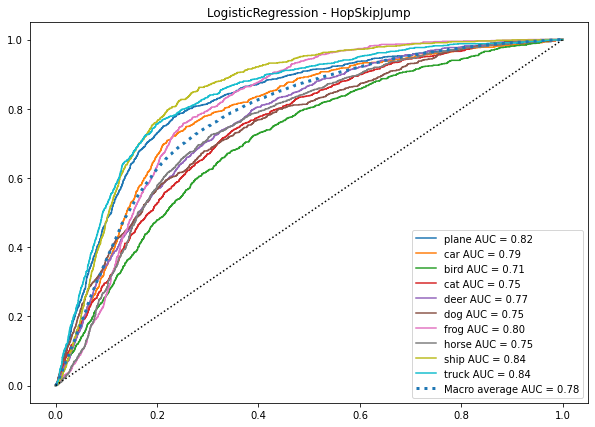

In [94]:
multiclass_roc_plot(y_test, lr_clf.predict_proba(x_test_hsj_lr), 'LogisticRegression - HopSkipJump')

In [95]:
# Try HopSkipJump attack on LDA model
load_lda_hsk_images = False
if load_lda_hsk_images:
    x_test_hsj_lda = load_images('LDA-HSJ')
else:
    lda_df_clf = SklearnClassifier(model=lda_clf, clip_values=(np.min(x_test_run), np.max(x_test_run)))
    attack = HopSkipJump(lda_df_clf, max_eval=500, max_iter=25)
    x_test_hsj_lda = attack.generate(x=x_test_run)
    save_images(x_test_hsj_lda, 'LDA-HSJ')

HopSkipJump:   0%|          | 0/10000 [00:00<?, ?it/s]

Saving LDA-HSJ-images.pkl


In [96]:
# Accumulate metrics
lda_hsj_results = model_metrics(lda_clf, x_test_hsj_lda, y_test_sk)
all_results['LDA-HSJ'] = lda_hsj_results
lda_hsj_results

{'Accuracy': 0.169,
 'Precision': 0.1722749768556458,
 'Recall': 0.16899999999999998,
 'F1': 0.16971476938951396,
 'AUC': 0.7769929777777778}

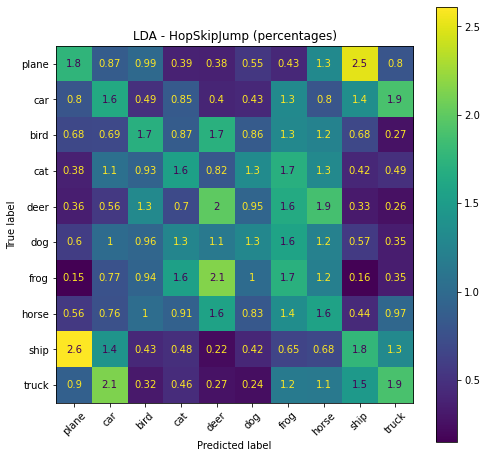

In [97]:
clf_cm(lda_clf, x_test_hsj_lda, y_test_sk, 'LDA - HopSkipJump')

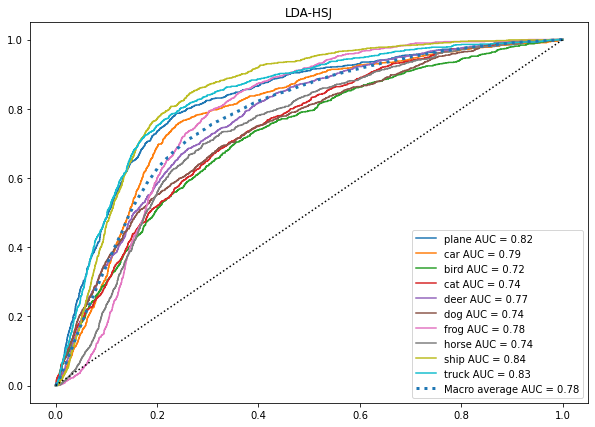

In [98]:
multiclass_roc_plot(y_test, lda_clf.predict_proba(x_test_hsj_lda), "LDA-HSJ")

In [99]:
from art.attacks.evasion import HopSkipJump
load_lsvc_hsk_images = False
if load_lsvc_hsk_images:
    x_test_lvsc_hsj = load_images('LSVC-HSJ')
else:
    lsvc_clf_hsj = SklearnClassifier(model=lsvc2_clf)
    lsvc_hsj_attack = HopSkipJump(lsvc_clf_hsj, max_eval=1000, max_iter=25)
    x_test_lvsc_hsj = lsvc_hsj_attack.generate(x=x_test_run)
    save_images(x_test_lvsc_hsj, 'LSVC-HSJ')

HopSkipJump:   0%|          | 0/10000 [00:00<?, ?it/s]

Saving LSVC-HSJ-images.pkl


In [100]:
# Accumulate metrics
lsvc_hsj_results = model_metrics(lsvc2_clf, x_test_lvsc_hsj, y_test_sk)
all_results['LinearSVC-HSJ'] = lsvc_hsj_results
lsvc_hsj_results

{'Accuracy': 0.1651,
 'Precision': 0.16848678593490057,
 'Recall': 0.16509999999999997,
 'F1': 0.16588362655831473,
 'AUC': 0.7764968}

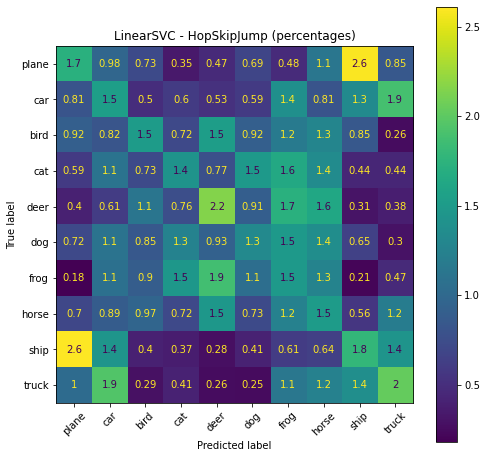

In [101]:
clf_cm(lsvc2_clf, x_test_lvsc_hsj, y_test_sk, 'LinearSVC - HopSkipJump')

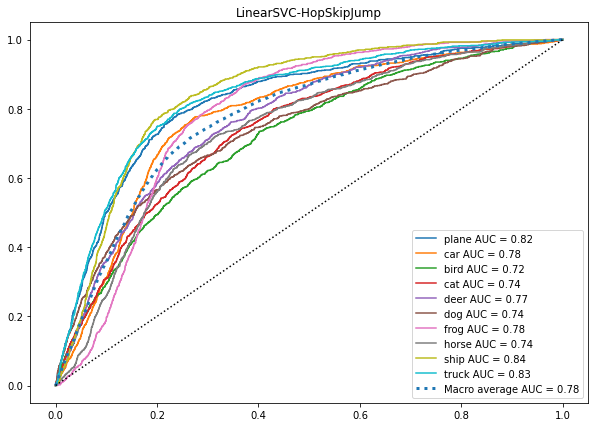

In [102]:
multiclass_roc_plot(y_test, lsvc2_clf.predict_proba(x_test_lvsc_hsj), "LinearSVC-HopSkipJump")

In [104]:
from art.attacks.evasion import HopSkipJump
load_ab_hsk_images = False
if load_ab_hsk_images:
    x_test_ab_hsj = load_images('AdaBoost-HSJ')
else:
    ab_clf_hsj = SklearnClassifier(model=ab_clf)
    ab_hsj_attack = HopSkipJump(ab_clf_hsj, max_eval=1000, max_iter=25)
    x_test_ab_hsj = ab_hsj_attack.generate(x=x_test_run, y=y_test_sk)
    save_images(x_test_ab_hsj, 'AdaBoost-HSJ')

In [105]:
# Accumulate metrics
ab_hsj_results = model_metrics(ab_clf, x_test_ab_hsj, y_test_sk)
all_results['AdaBoost-HSJ'] = ab_hsj_results
ab_hsj_results

{'Accuracy': 0.3491,
 'Precision': 0.34216813354999087,
 'Recall': 0.34909999999999997,
 'F1': 0.3413452406353372,
 'AUC': 0.7766645333333333}

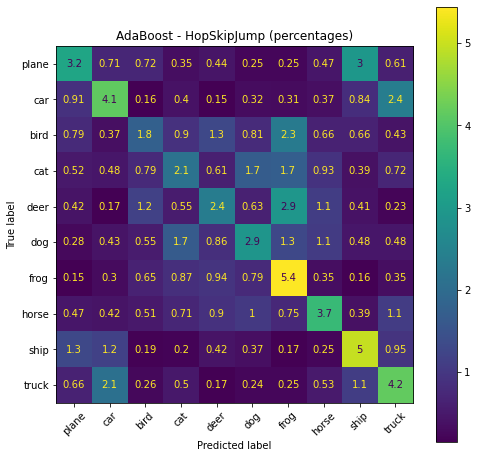

In [106]:
clf_cm(ab_clf, x_test_ab_hsj, y_test_sk, 'AdaBoost - HopSkipJump')

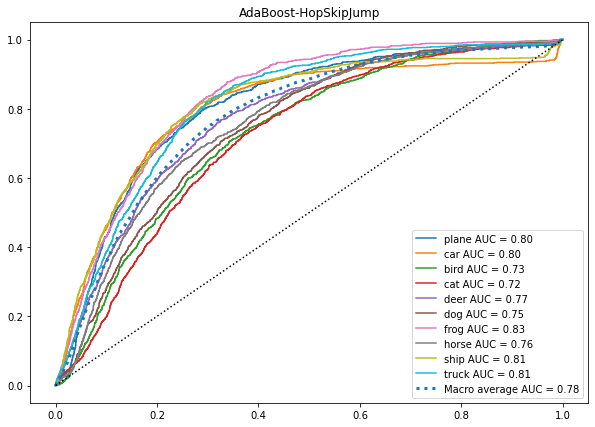

In [107]:
multiclass_roc_plot(y_test, ab_clf.predict_proba(x_test_ab_hsj), "AdaBoost-HopSkipJump")

In [108]:
from art.attacks.evasion import HopSkipJump
load_dt_hsj_images = False
if load_dt_hsj_images:
    x_test_hsj_dt = load_images('DecisionTree-HSJ')
else:
    dt_hsj_clf = SklearnClassifier(model=dt_clf, clip_values=(np.min(x_test_run), np.max(x_test_run)))
    dt_hsj_attack = HopSkipJump(dt_hsj_clf, max_eval=1000, max_iter=25)
    x_test_hsj_dt = dt_hsj_attack.generate(x=x_test_run)
    save_images(x_test_hsj_dt, 'DecisionTree-HSJ')

HopSkipJump:   0%|          | 0/10000 [00:00<?, ?it/s]

Saving DecisionTree-HSJ-images.pkl


In [109]:
# Accumulate metrics
dt_hsj_results = model_metrics(dt_clf, x_test_hsj_dt, y_test_sk)
all_results['DecisionTree-HSJ'] = dt_hsj_results
dt_hsj_results

{'Accuracy': 0.1684,
 'Precision': 0.17041673126008644,
 'Recall': 0.1684,
 'F1': 0.16810691196690267,
 'AUC': 0.6272557944444443}

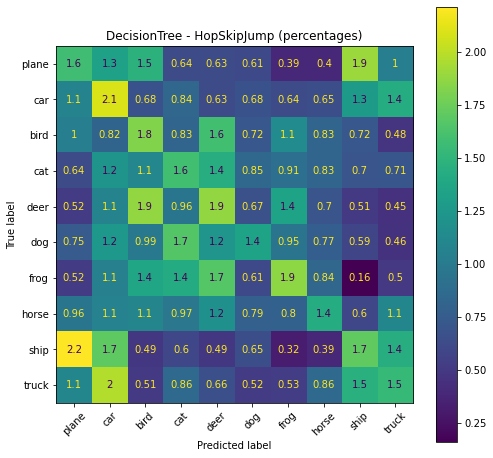

In [110]:
clf_cm(dt_clf, x_test_hsj_dt, y_test_sk, 'DecisionTree - HopSkipJump')

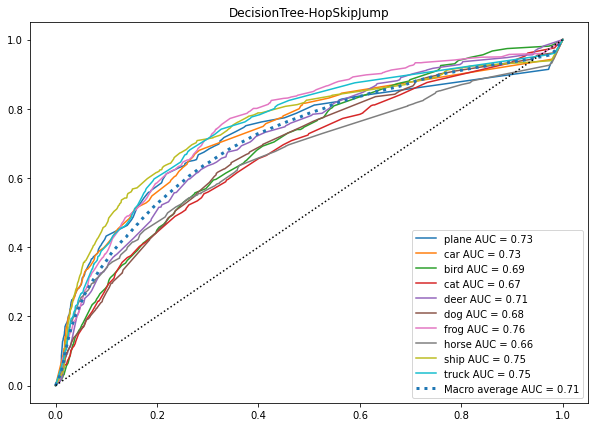

In [111]:
roc_multi2(dt_clf, x_train_run, y_train, x_test_hsj_dt, y_test, 'DecisionTree-HopSkipJump')

In [112]:
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import image_perturbations
attack = PoisoningAttackBackdoor([image_perturbations.add_single_bd, image_perturbations.add_pattern_bd, image_perturbations.add_pattern_bd, image_perturbations.add_pattern_bd])
x_poison, y_poison = attack.poison(x_train, y_train)
x_poison_run, y_poison_sk = attack.poison(x_train, y_train_sk)

#flattened, non one hot encoded data for vanilla sklearn classifiers
x_poison_run = np.reshape(x_poison_run, (x_poison_run.shape[0], -1))# [10000, 3072]
# Run PCA to reduce number of features
#pca = PCA(.90) # number of components to cover 90%
x_poison_run = pca.fit_transform(x_poison_run)


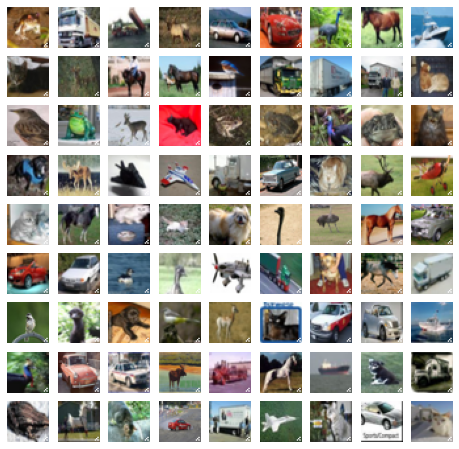

In [113]:
display_imgs(9, 9, x_poison)

In [114]:
dt_poisoned = {'max_depth': (10, 20, 50), 'max_features': ('auto', None)}
runGridSearch(DecisionTreeClassifier(), dt_poisoned, x_poison_run, y_poison_sk, x_test_run, y_test_sk)

*****Estimator: DecisionTreeClassifier() ********
Fitting 5 folds for each of 6 candidates, totalling 30 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.3359        0.0058           0.0029      1.9905e-04   
1         3.2528        0.0303           0.0025      1.8182e-06   
2         0.4893        0.0166           0.0037      2.4261e-04   
3         4.6745        0.0439           0.0034      1.9787e-04   
4         0.5251        0.0173           0.0042      4.9835e-04   
5         4.7789        0.0779           0.0040      9.9182e-04   

  param_max_depth param_max_features  \
0              10               auto   
1              10               None   
2              20               auto   
3              20               None   
4              50               auto   
5              50               None   

                                      params  split0_test_score  \
0  {'max_depth': 10, 'max_features': 'auto'}             0.2413   
1    {'max_depth': 10, 'max_features': None}             0.3063   
2  {'max_depth': 20, 'max_features': 'auto'}             0.2218   
3    {'max_depth': 20, 'max_features': None}             0.2665   
4  {'max_depth': 50, 'max_features': 'auto'}             0.2210   
5    {'max_depth': 50, 'max_features': None}             0.2602   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0             0.2493             0.2407             0.2470             0.2686   
1             0.3024             0.3100             0.3063             0.3047   
2             0.2317             0.2225             0.2287             0.2308   
3             0.2608             0.2702             0.2619             0.2670   
4             0.2208             0.2295             0.2225             0.2031   
5             0.2607             0.2660             0.2626             0.2576   

   mean_test_score  std_test_score  rank_test_score  
0           0.2494          0.0102                4  
1           0.3059          0.0025                1  
2           0.2271          0.0042                5  
3           0.2653          0.0035                2  
4           0.2194          0.0087                6  
5           0.2614          0.0028                3

DecisionTreeClassifier(max_depth=10)
   Best train score: 0.30594
   test accuracy=0.2563
   Best params: {'max_depth': 10, 'max_features': None}


DecisionTreeClassifier(max_depth=10)

In [115]:
# Accumulate metrics
dt_poison_clf = DecisionTreeClassifier(max_depth=10, max_features=None)
dt_poison_clf.fit(x_poison_run, y_poison_sk)
dt_poison_results = model_metrics(dt_poison_clf, x_test_run, y_test_sk)
all_results['Decision Tree-Poisoning'] = dt_poison_results
dt_poison_results

{'Accuracy': 0.2556,
 'Precision': 0.25330031906613926,
 'Recall': 0.2556,
 'F1': 0.2511440469798178,
 'AUC': 0.6803758277777778}

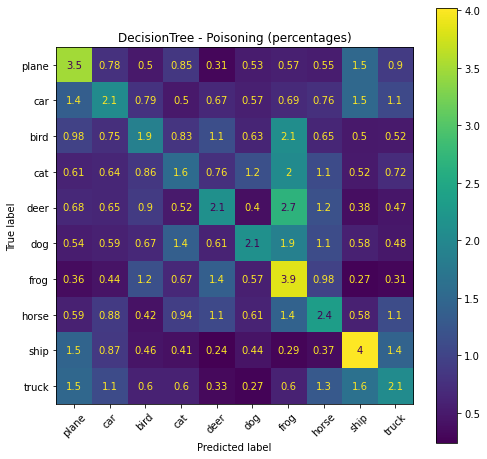

In [116]:
clf_cm(dt_poison_clf, x_test_run, y_test_sk, 'DecisionTree - Poisoning')

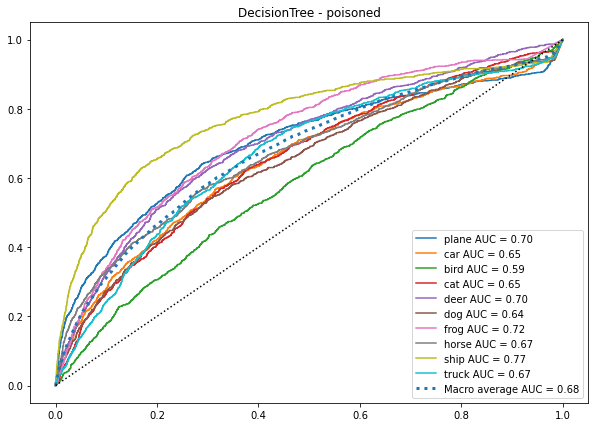

In [117]:
roc_multi2(dt_poison_clf, x_poison_run, y_poison_sk, x_test_run, y_test_sk, 'DecisionTree - poisoned')

In [118]:
rf_poisoned = {'n_estimators': (25,50,100), 'max_depth':(10,50,100)}
runGridSearch(RandomForestClassifier(n_jobs=4), rf_poisoned , x_poison_run, y_poison_sk, x_test_run, y_test_sk)

*****Estimator: RandomForestClassifier(n_jobs=4) ********
Fitting 5 folds for each of 9 candidates, totalling 45 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         2.4245        0.0813           0.0222          0.0053   
1         4.5905        0.0681           0.0463          0.0284   
2         8.4935        0.2923           0.0510          0.0017   
3         3.3533        0.0496           0.0316          0.0010   
4         6.3927        0.0688           0.0547          0.0020   
5        12.9682        0.5152           0.0971          0.0015   
6         3.4100        0.0454           0.0475          0.0331   
7         7.2731        0.8247           0.0525          0.0022   
8        11.8985        1.1806           0.0904          0.0168   

  param_max_depth param_n_estimators                                   params  \
0              10                 25    {'max_depth': 10, 'n_estimators': 25}   
1              10                 50    {'max_depth': 10, 'n_estimators': 50}   
2              10                100   {'max_depth': 10, 'n_estimators': 100}   
3              50                 25    {'max_depth': 50, 'n_estimators': 25}   
4              50                 50    {'max_depth': 50, 'n_estimators': 50}   
5              50                100   {'max_depth': 50, 'n_estimators': 100}   
6             100                 25   {'max_depth': 100, 'n_estimators': 25}   
7             100                 50   {'max_depth': 100, 'n_estimators': 50}   
8             100                100  {'max_depth': 100, 'n_estimators': 100}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0             0.4073             0.3957             0.4027             0.3952   
1             0.4277             0.4186             0.4216             0.4084   
2             0.4394             0.4257             0.4318             0.4212   
3             0.3801             0.3772             0.3756             0.3705   
4             0.4188             0.4148             0.4224             0.4146   
5             0.4585             0.4471             0.4610             0.4491   
6             0.3754             0.3692             0.3742             0.3690   
7             0.4272             0.4066             0.4294             0.4133   
8             0.4591             0.4504             0.4565             0.4488   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0             0.4032           0.4008          0.0047                7  
1             0.4180           0.4189          0.0063                4  
2             0.4266           0.4289          0.0062                3  
3             0.3822           0.3771          0.0040                8  
4             0.4236           0.4188          0.0037                5  
5             0.4506           0.4533          0.0055                2  
6             0.3820           0.3740          0.0048                9  
7             0.4159           0.4185          0.0086                6  
8             0.4526           0.4535          0.0038                1

RandomForestClassifier(max_depth=100, n_jobs=4)
   Best train score: 0.45348
   test accuracy=0.3726
   Best params: {'max_depth': 100, 'n_estimators': 100}


RandomForestClassifier(max_depth=100, n_jobs=4)

In [119]:
# Accumulate metrics
rf_poison_clf = RandomForestClassifier(n_jobs=4, n_estimators=100, max_depth = 100)
rf_poison_clf.fit(x_poison_run, y_poison_sk)
rf_poison_results = model_metrics(rf_poison_clf, x_test_run, y_test_sk)
all_results['Random Forest-Poisoning'] = rf_poison_results
rf_poison_results

{'Accuracy': 0.3711,
 'Precision': 0.36870515114186486,
 'Recall': 0.37110000000000004,
 'F1': 0.3668709647504779,
 'AUC': 0.7925762111111112}

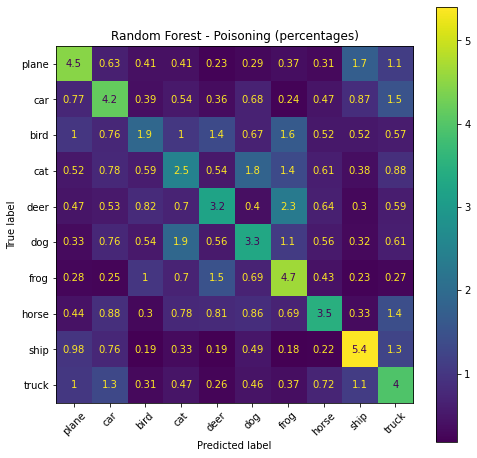

In [120]:
clf_cm(rf_poison_clf, x_test_run, y_test_sk, 'Random Forest - Poisoning')

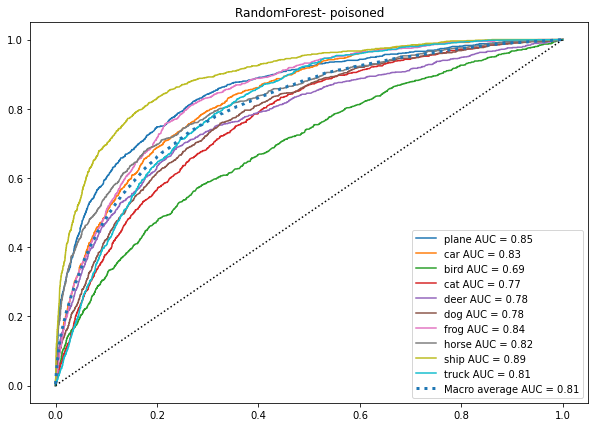

In [121]:
roc_multi2(rf_poison_clf, x_poison_run, y_poison_sk, x_test_run, y_test_sk, 'RandomForest- poisoned')

In [122]:
lr_poisoned = {'penalty': ('l2', 'none'), 'tol': (1.0e-2, 1.0e-4)}
runGridSearch(LogisticRegression(solver='saga', multi_class='multinomial'), lr_poisoned, x_poison_run, y_poison_sk, x_test_run, y_test_sk)

*****Estimator: LogisticRegression(multi_class='multinomial', solver='saga') ********
Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_penalty  \
0         1.4462        0.1156           0.0587          0.0525            l2   
1        17.8266        0.1620           0.0022          0.0005            l2   
2         1.3208        0.0419           0.0021          0.0002          none   
3         3.1451        0.1499           0.0020          0.0003          none   

  param_tol                              params  split0_test_score  \
0      0.01      {'penalty': 'l2', 'tol': 0.01}             0.4023   
1    0.0001    {'penalty': 'l2', 'tol': 0.0001}             0.4027   
2      0.01    {'penalty': 'none', 'tol': 0.01}             0.4015   
3    0.0001  {'penalty': 'none', 'tol': 0.0001}             0.4027   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0             0.3869             0.4071             0.3952             0.3917   
1             0.3865             0.4064             0.3959             0.3922   
2             0.3866             0.4071             0.3954             0.3915   
3             0.3864             0.4063             0.3958             0.3922   

   mean_test_score  std_test_score  rank_test_score  
0           0.3966          0.0072                3  
1           0.3967          0.0071                1  
2           0.3964          0.0072                4  
3           0.3967          0.0071                2

LogisticRegression(multi_class='multinomial', solver='saga')
   Best train score: 0.39674
   test accuracy=0.3122
   Best params: {'penalty': 'l2', 'tol': 0.0001}


LogisticRegression(multi_class='multinomial', solver='saga')

In [123]:
# Accumulate metrics
lr_poison_clf = LogisticRegression(solver='saga', multi_class='multinomial', penalty='l2', tol=.001)
lr_poison_clf.fit(x_poison_run, y_poison_sk)
lr_poison_results = model_metrics(lr_poison_clf, x_test_run, y_test_sk)
all_results['Logistic Regression - Poisoning'] = lr_poison_results
lr_poison_results

{'Accuracy': 0.312,
 'Precision': 0.3069637376642228,
 'Recall': 0.31199999999999994,
 'F1': 0.30797344224037937,
 'AUC': 0.74726425}

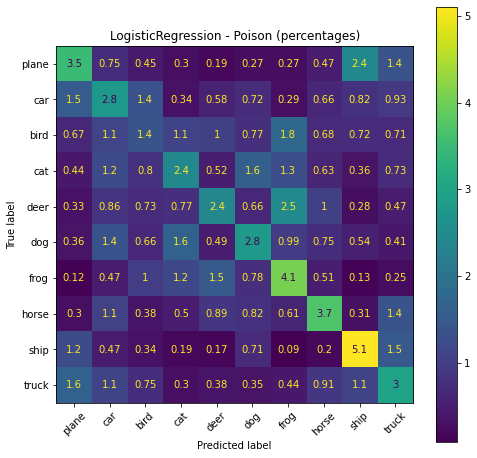

In [124]:
clf_cm(lr_poison_clf, x_test_run, y_test_sk, 'LogisticRegression - Poison')

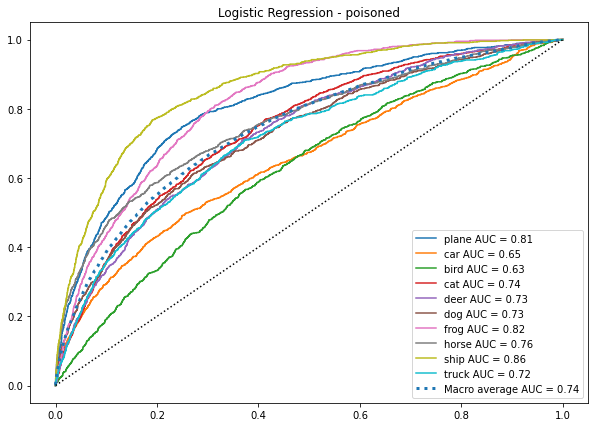

In [125]:
roc_multi2(lr_poison_clf, x_poison_run, y_poison_sk, x_test_run, y_test_sk, 'Logistic Regression - poisoned')

In [127]:
# Fit
cnn_poisoned = model.fit(
  x_poison, y_poison, validation_split=0.33, epochs=10)

Train on 33500 samples, validate on 16500 samples
Epoch 1/10
33500/33500 [==============================] - 51s 2ms/sample - loss: 0.4581 - accuracy: 0.8398 - auc: 0.9860 - precision: 0.8778 - recall: 0.8078 - val_loss: 0.3518 - val_accuracy: 0.8784 - val_auc: 0.9921 - val_precision: 0.9163 - val_recall: 0.8411
Epoch 2/10
33500/33500 [==============================] - 47s 1ms/sample - loss: 0.4040 - accuracy: 0.8596 - auc: 0.9889 - precision: 0.8883 - recall: 0.8301 - val_loss: 0.3837 - val_accuracy: 0.8682 - val_auc: 0.9907 - val_precision: 0.9081 - val_recall: 0.8254
Epoch 3/10
33500/33500 [==============================] - 48s 1ms/sample - loss: 0.3686 - accuracy: 0.8703 - auc: 0.9905 - precision: 0.8976 - recall: 0.8447 - val_loss: 0.4046 - val_accuracy: 0.8600 - val_auc: 0.9887 - val_precision: 0.8960 - val_recall: 0.8284
Epoch 4/10
33500/33500 [==============================] - 44s 1ms/sample - loss: 0.3657 - accuracy: 0.8729 - auc: 0.9904 - precision: 0.8986 - recall: 0.8499 - v

In [129]:
# Accumulate metrics
cnn_poison_results = model_metrics_cnn(model, x_test, y_test)
all_results['CNN-poison'] = cnn_poison_results
cnn_poison_results

{'Accuracy': 0.7852,
 'Precision': 0.82111186,
 'Recall': 0.7592,
 'F1': 0.7889431861996673,
 'AUC': 0.96684235}

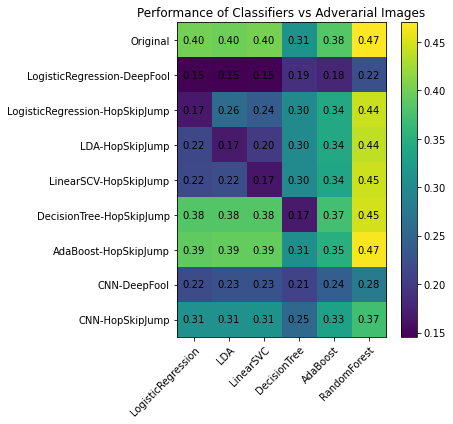

In [130]:
# Generate PCA-transformed versions of CNN DF and HSJ images
x_test_df_cnn_pca = pca.transform(np.reshape(x_test_df_cnn, (x_test_df_cnn.shape[0], -1)))
x_test_hsj_cnn_pca = pca.transform(np.reshape(x_test_hsj_cnn, (x_test_hsj_cnn.shape[0], -1)))

# Dictionary of classifer name/object
classifiers = {'LogisticRegression': lr_clf, 'LDA': lda_clf, 'LinearSVC': lsvc2_clf, 'DecisionTree': dt_clf, 'AdaBoost': ab_clf, 'RandomForest': rf_clf}
# Dictionary of images name/object
adv_imgs = {'Original': x_test_run, 'LogisticRegression-DeepFool': x_test_df_lr, 'LogisticRegression-HopSkipJump': x_test_hsj_lr,
            'LDA-HopSkipJump': x_test_hsj_lda, 'LinearSCV-HopSkipJump': x_test_lvsc_hsj,
            'DecisionTree-HopSkipJump': x_test_hsj_dt,
            'AdaBoost-HopSkipJump': x_test_ab_hsj,
            'CNN-DeepFool': x_test_df_cnn_pca, 'CNN-HopSkipJump':x_test_hsj_cnn_pca}

n_classifiers = len(classifiers)
n_adv_imgs = len(adv_imgs)

# Create 2d Array of accuracy scores
scores = np.zeros(shape=(n_adv_imgs, n_classifiers))
for i, img_name in enumerate(adv_imgs.keys()):
    for j, clf_name in enumerate(classifiers.keys()):
        scores[i, j] = metrics.accuracy_score(y_test_sk, classifiers[clf_name].predict(adv_imgs[img_name]))

# Draw the plot. This is based on a matplotlib heatmap example.
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(scores)
fig.colorbar(im, ax=ax)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(n_classifiers))
ax.set_xticklabels(labels=list(classifiers.keys()))
ax.set_yticks(np.arange(n_adv_imgs))
ax.set_yticklabels(labels=list(adv_imgs.keys()))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add accuracy text to the plot
for i in range(n_adv_imgs):
    for j in range(n_classifiers):
        acc = '{:.2f}'.format(scores[i, j])
        #print(clf_name, img_name, acc)
        text = ax.text(j, i, acc, ha="center", va="center")

ax.set_title("Performance of Classifiers vs Adverarial Images")
fig.tight_layout()
plt.show()


In [132]:
df = pd.DataFrame.from_dict(all_results, orient='index')
pd.set_option("display.precision", 4)
display(df)

Accuracy  Precision  Recall      F1     AUC
LDA                                0.3989     0.3948  0.3989  0.3958  0.8123
LogisticRegression                 0.4021     0.3971  0.4021  0.3983  0.8145
DecisionTree                       0.3122     0.3123  0.3122  0.3096  0.7303
AdaBoost                           0.3846     0.3766  0.3846  0.3718  0.8096
RandomForest                       0.4701     0.4662  0.4701  0.4668  0.8477
LinearSVC                          0.4031     0.3971  0.4031  0.3976  0.8078
CNN                                0.7780     0.8216  0.7419  0.7797  0.9695
CNN-DF                             0.1366     0.0691  0.0412  0.0516  0.7218
CNN-HSJ                            0.0958     0.0522  0.0334  0.0407  0.8762
LogisticRegression-DF              0.1476     0.1790  0.1476  0.1501  0.5525
LogisticRegression-HSJ             0.1675     0.1693  0.1675  0.1680  0.7813
LDA-HSJ                            0.1690     0.1723  0.1690  0.1697  0.7770
LinearSVC-HSJ                      0.1651     0.1685  0.1651  0.1659  0.7765
AdaBoost-HSJ                       0.3491     0.3422  0.3491  0.3413  0.7767
DecisionTree-HSJ                   0.1684     0.1704  0.1684  0.1681  0.6273
Decision Tree-Poisoning            0.2556     0.2533  0.2556  0.2511  0.6804
Random Forest-Poisoning            0.3711     0.3687  0.3711  0.3669  0.7926
Logistic Regression - Poisoning    0.3120     0.3070  0.3120  0.3080  0.7473
CNN-poison                         0.7852     0.8211  0.7592  0.7889  0.9668